In [3]:
import plotting_functions
import pandas as pd

# Exploratory Analysis of Real Commodities Data

## Currency Basket

We choose the returns of three currencies which are heavily linked to the performance of commodities marketsin order to create a market benchmark against which to compare the performance of each commodity. To this end, we consider the average of the returns of the Canadian Dollar (CAD), Australian Dollar (AUD), and the Mexican Peso when paired with the US Dollar (USD). The resulting augmented "commodities currency basket" series is analysed in this section.

In [140]:
# Create list of currency names
currency_list = ['CME Australian Dollar AUD',
                 'CME Mexican Peso',
                 'CME Canadian Dollar CAD']

# Initialise empty dataframes with full indexing
currency_dict = {currency:  pd.DataFrame([], index = pd.bdate_range(start = '1/1/1980', end = '7/31/2020')) for currency in currency_list}

# Loop through each currency and load the data into the waiting dataframne
for currency in currency_list:
    
    current_df = pd.read_csv('Data/Continuous Futures Series/{}.csv'.format(currency), index_col = 0, skiprows = 0, skipfooter = 1, header = 1, engine = 'python')
    current_df.index = pd.to_datetime(current_df.index)
    
    currency_dict[currency] = currency_dict[currency].join(current_df)

In [141]:
from plotting_functions import series_plot

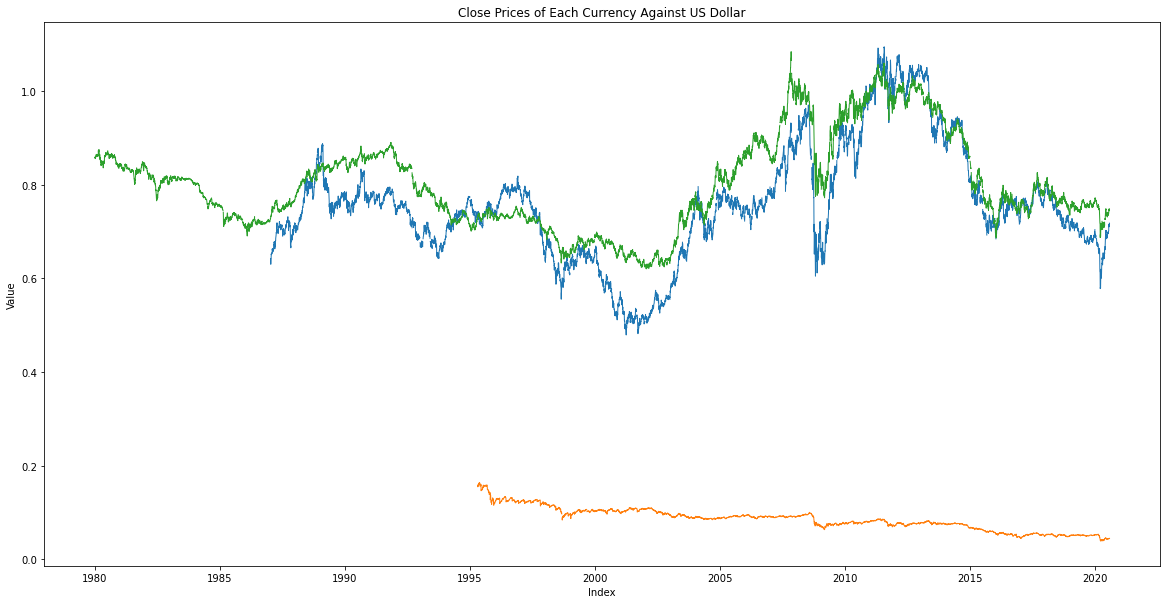

In [142]:
# Create empty dataframe of currency close prices to be filled in
currency_close_df = pd.DataFrame([], index = currency_dict['CME Canadian Dollar CAD'].index)

# Loop through each currency dataframe and pull its close price data
for currency in currency_list:
    
    currency_close_df[currency] = currency_dict[currency]['Close']
    
series_plot(currency_close_df,'Close Prices of Each Currency Against US Dollar')

While the North American currencies have data available back to 1980, the AUD series begins at 1995. This will not be an issue, as 24 years of available daily data will be more than suitable for our purposes, and we will see that our useable data range will be limited by similar constraints on the commodities returns data.

### Simple Average of Currencies

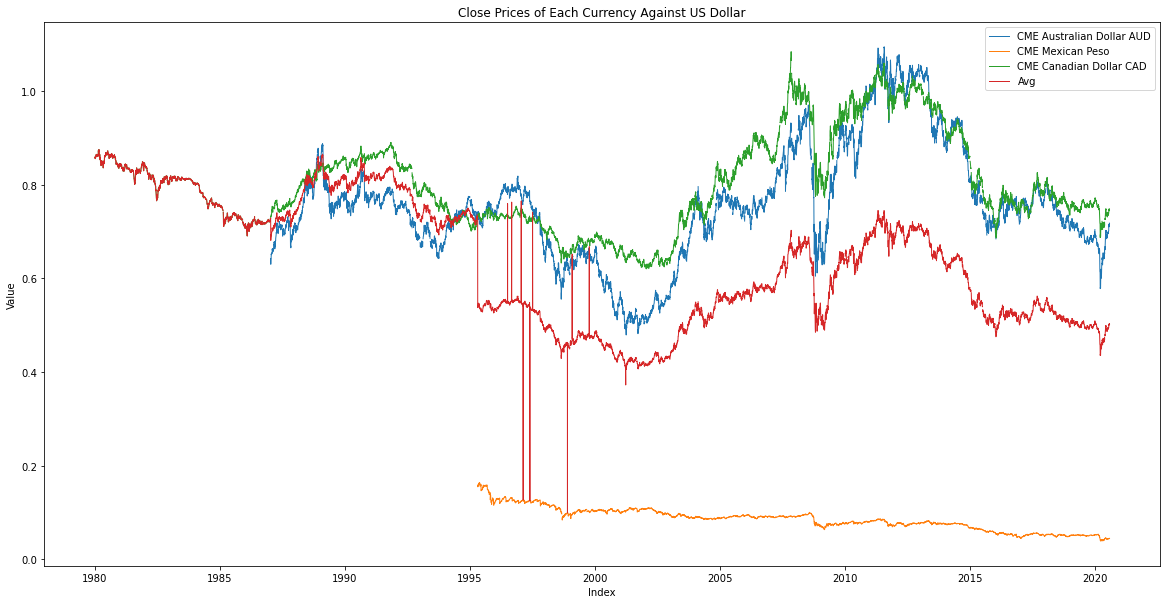

In [146]:
currency_close_df_copy = currency_close_df.copy()
currency_close_df_copy['Avg'] = currency_close_df.copy().mean(axis=1)

series_plot(currency_close_df_copy,'Close Prices of Each Currency Against US Dollar',legend=True)

The sharp spikes in the plotted data are a result of gaps in either the North American or Australian currencies. A sharp spike up is a result of missing data in the AUD, while a sharp spike down is caused by missing data in CAD and the Peso series. This is confirmed by the following plot, which is the same as the plot above but with missing data filled backwards.

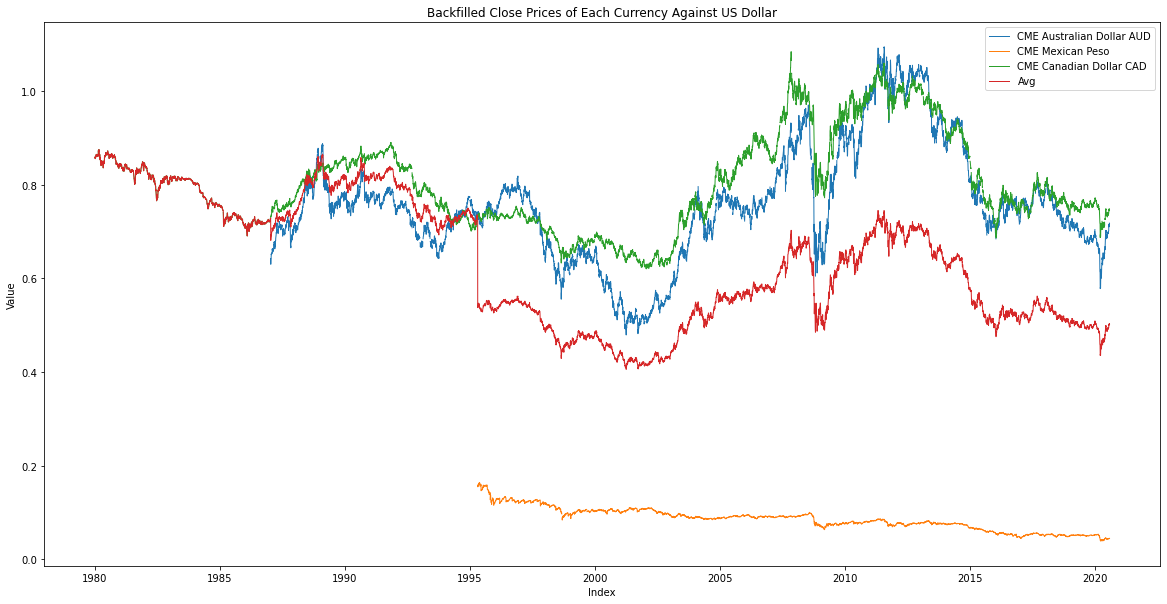

In [147]:
currency_close_df['Avg'] = currency_close_df.fillna(method='ffill').mean(axis=1)

series_plot(currency_close_df,'Backfilled Close Prices of Each Currency Against US Dollar', legend=True)

### Distribution of Currencies Returns

Many results necessitate the assumption that returns data is approximately normally distributed. Here, we aim to validate that claim for our data. First, we constuct a series for each of our currencies which is mean-zero and standardised by 
rolling estimate of its standard deviation. Empircally, we can show that a rolling period longer than this overeastimates the variance of the returns, and a shorter window underestimates it. This may be because the window size begins to take into account data from a distribution too different from the observation on the current day, a theme we will revisit often during this project. This also suggests that the data is not stationary, as the observations do not have constant variance.

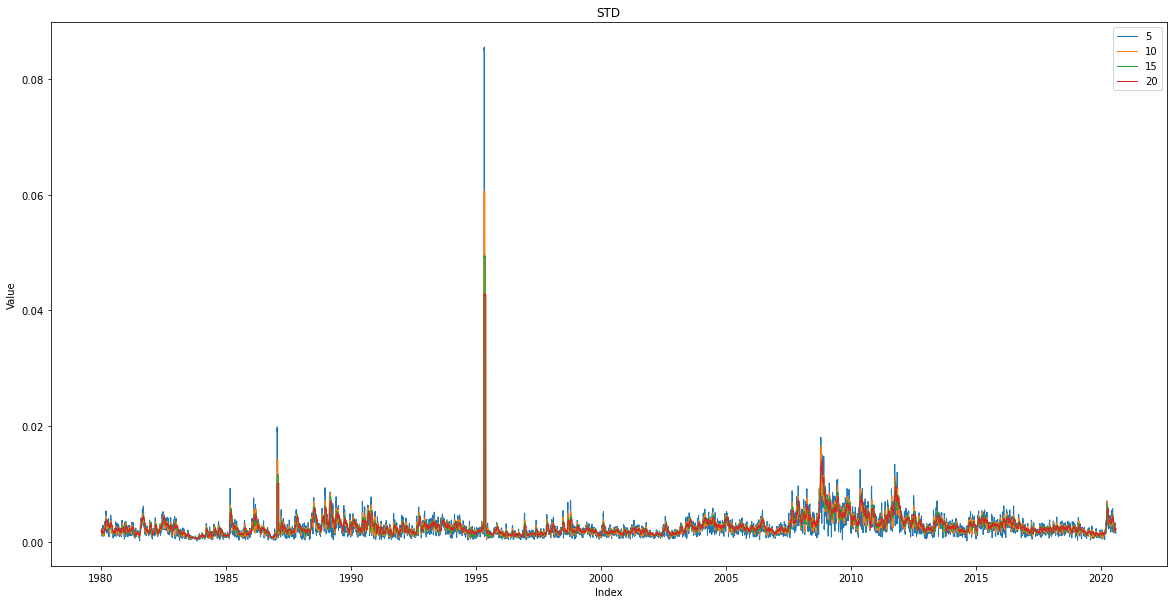

In [279]:
std_plot = pd.DataFrame([], index=currency_close_df.index)
for window_size in [5,10,15,20]:
    std_plot[window_size] = currency_close_df['Avg'].diff().rolling(window_size,min_periods=1).std()
series_plot(std_plot,'STD',legend=True)

In [256]:
# Normalised return dataframe
norm_currency_returns = pd.DataFrame([]).reindex_like(currency_close_df)

# Fill datafrane
for currency in currency_close_df:
    
    currency_std_series = currency_close_df[currency].rolling(1000, min_periods = 1).std()
    
    norm_currency_returns[currency] = currency_close_df[currency].diff(periods=1) / currency_std_series
norm_currency_returns

,CME Australian Dollar AUD,CME Mexican Peso,CME Canadian Dollar CAD,Avg
1980-01-01,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,-1.414214,-1.414214
1980-01-04,NaN,NaN,1.732051,1.732051
1980-01-07,NaN,NaN,-2.109488,-2.109488
...,...,...,...,...
2020-07-27,0.102790,0.154505,0.156519,0.131832
2020-07-28,0.045701,0.068242,-0.002236,0.033733
2020-07-29,0.018288,-0.059250,-0.006706,0.006964
2020-07-30,0.018294,-0.038452,-0.192192,-0.056183


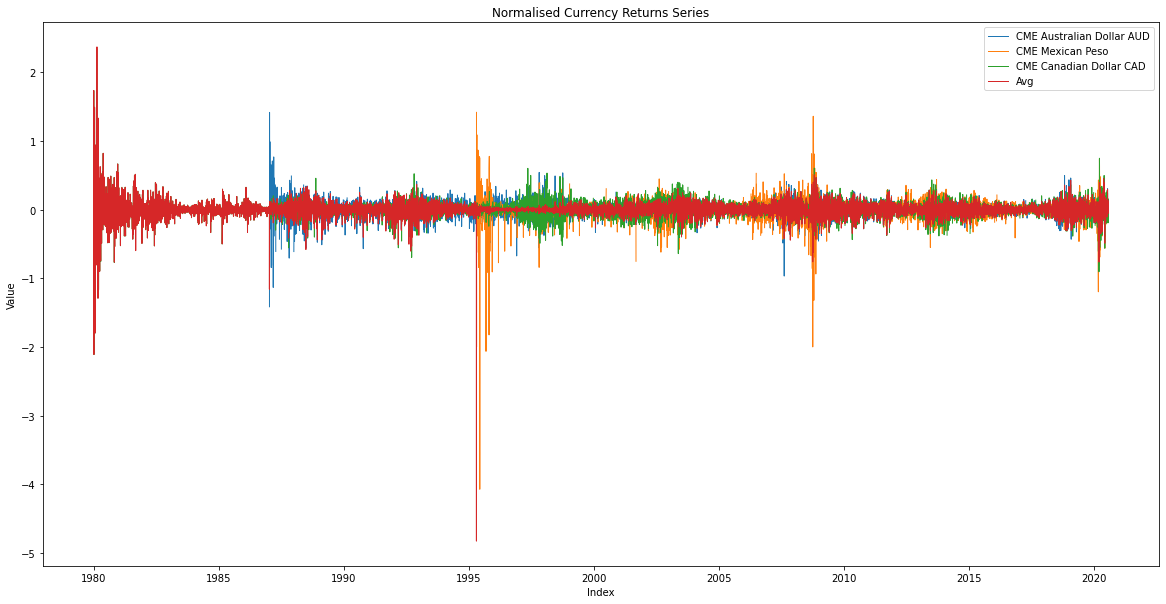

In [257]:
series_plot(norm_currency_returns,'Normalised Currency Returns Series', legend=True)

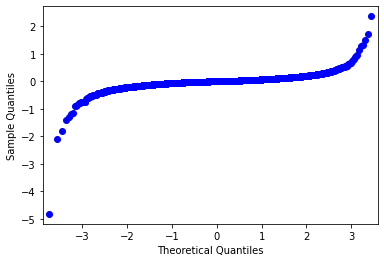

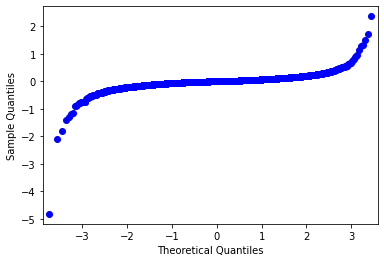

In [258]:
from statsmodels.graphics.gofplots import qqplot
qqplot(norm_currency_returns['Avg'])

With the choice of rolling estimate window size as outliend above, the QQ plots of the sample distribution indicate that the returns are approximately standard normally distributed. This is supported by the below Kernal Density Estimation of the currencies' average sample distribution.

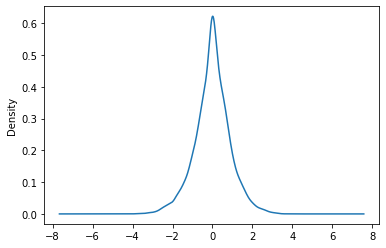

In [210]:
norm_currency_returns['Avg'].plot.kde()

### AutoCorrelation Plots


Now we check the autocorrelation function of the currencies' simple average. As it is the mean of three series with zero ACF, we expect this too to be zero.

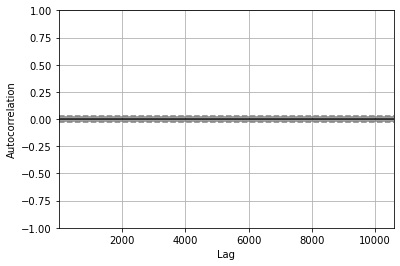

In [188]:
pd.plotting.autocorrelation_plot(norm_currency_returns['Avg'])

The simple average of the currencies has near zero autocorrelation at all lags. This validates our choice to not include auto-correlation structure to the currency composite.

## Commodities

### Data Validation

First we check that our assumption that these currencies work as a suitable benchmark for the commodities market as a whole. We do this by finding the correlation of this baskets returns with the returns of the rest of the market.